EMT solver main function
2020-2024 Bin Wang, Min Xiong, Deepthi Vaidhynathan, Jonathan Maack
Last modified: 8/15/24

This is the main function for running an EMT simulation case in Google Colab, 
which does not require setting up environment, and can run in a browser.

In [3]:
# Run this part only once for setting up environment

# Below for releasing the existing guthub files
# !rm -rf ParaEMT_public
# !git fetch --all
# !git reset --hard origin/test

# Clone the test branch of your repository
import os, sys, shutil
!git clone --branch test https://github.com/NREL/ParaEMT_public.git
os.chdir('/content/ParaEMT_public')
sys.path.append('/content/ParaEMT_public')  # or the correct subdirectory path
!pip install -r requirements.txt

os.chdir('/content/ParaEMT_public')
sys.path.append('/content/ParaEMT_public')  # or the correct subdirectory path
!pip install -r requirements.txt

In [4]:
import time
import os
import numpy as np
from Lib_BW import *
from psutils import *
from preprocessscript import get_json_pkl
import matplotlib.pyplot as plt
import pandas as pd

workingfolder = '.'
os.chdir(workingfolder)

Then, configure some of the simulation settings:

In [5]:
SimMod = 1  # 0 - Save a snapshot, 1 - run from a snapshot
DSrate = 10 # down sampling rate, i.e. results saved every DSrate sim steps.
systemN = 6 # 1: 2-gen, 2: 9-bus, 3: 39-bus, 4: 179-bus, 5: 240-bus, 6: 2-area
N_row = 1  # haven't tested the mxn layout, so plz don't set N_row/N_col to other nums.
N_col = 1

ts = 50e-6  # time step, second
Tlen = 10  # total simulation time length, second
t_release_f = 0.0
loadmodel_option = 1  # 1-const rlc, 2-const z
netMod = 'lu'
nparts = 2 # number of blocks in BBD form

Initialize EMT simulation:

In [6]:
output_snp_ful = 'sim_snp_S' + str(systemN) + '_' + str(int(ts * 1e6)) + 'u.pkl'
output_snp_1pt = 'sim_snp_S' + str(systemN) + '_' + str(int(ts * 1e6)) + 'u_1pt.pkl'
output_res = 'sim_res_S' + str(systemN) + '_' + str(int(ts * 1e6)) + 'u.pkl'
input_snp = 'sim_snp_S' + str(systemN) + '_' + str(int(ts * 1e6)) + 'u_1pt.pkl'

t0 = time.time()
if SimMod == 0:
    (pfd, ini, dyd, emt) = initialize_emt(workingfolder, systemN, N_row, N_col, ts, Tlen, mode = netMod, nparts=nparts)
else:
    (pfd, ini, dyd, emt) = initialize_from_snp(input_snp, netMod, nparts)


     ____                 _____ __  __ _____ 
    |  _ \ __ _ _ __ __ _| ____|  \/  |_   _|
    | |_) / _` | '__/ _` |  _| | |\/| | | |  
    |  __/ (_| | | | (_| | |___| |  | | | |   copyright: NREL
    |_|   \__,_|_|  \__,_|_____|_|  |_| |_|   email: ParaEMT@nrel.gov
    
System initialized
Compiling the code


Configure disturbance settings:

In [7]:
# ctrl step change
emt.t_sc = 1
emt.i_gen_sc = 0
emt.flag_exc_gov = 1  # 0 - exc, 1 - gov
emt.dsp = - 0.02
emt.flag_sc = 1 # default, do not change

# gen trip
emt.t_gentrip = 200
emt.i_gentrip = 1   # 0: 1032 C for WECC 240-bus
emt.flag_gentrip = 1 
emt.flag_reinit = 1

Run time domain simulation:

In [8]:
# Before t = t_release_f, PLL freq are fixed at synchronous freq
emt.t_release_f = t_release_f
emt.loadmodel_option = loadmodel_option  # 1-const rlc, 2-const z

# time loop
Nsteps = 0
tn = 0
tsave = 0
while tn*ts < Tlen:
    tn = tn + 1
    emt.StepChange(dyd, ini, tn)                # configure step change in exc or gov references
    emt.GenTrip(pfd, dyd, ini, tn, netMod)      # configure generation trip
    emt.predictX(pfd, dyd, emt.ts)
    emt.Igs = emt.Igs * 0
    emt.updateIg(pfd, dyd, ini)
    emt.Igi = emt.Igi * 0
    emt.Iibr = emt.Iibr * 0
    emt.updateIibr(pfd, dyd, ini)
    if emt.loadmodel_option == 1:
        pass
    else:
        emt.Il = emt.Il * 0
        emt.updateIl(pfd, dyd, tn)   # update current injection from load
    emt.solveV(ini)
    emt.BusMea(pfd, dyd, tn)     # bus measurement
    emt.updateX(pfd, dyd, ini, tn)
    emt.updateXibr(pfd, dyd, ini, ts)
    if emt.loadmodel_option == 1:
        pass
    else:
        emt.updateXl(pfd, dyd, tn)
    emt.x_pred = {0:emt.x_pred[1],1:emt.x_pred[2],2:emt.x_pv_1}

    if np.mod(tn, DSrate) == 0:
        tsave = tsave + 1
        # save states
        emt.t.append(tn * ts)
        print("%.4f" % emt.t[-1])
        emt.x[tsave] = emt.x_pv_1.copy()
        if len(pfd.ibr_bus) > 0:
            emt.x_ibr[tsave] = emt.x_ibr_pv_1.copy()
        if len(pfd.bus_num) > 0:
            emt.x_bus[tsave] = emt.x_bus_pv_1.copy()
        if len(pfd.load_bus) > 0:
            emt.x_load[tsave] = emt.x_load_pv_1.copy()
        emt.v[tsave] = emt.Vsol.copy()
    # re-init
    if (emt.flag_gentrip == 0) & (emt.flag_reinit == 1):
        emt.Re_Init(pfd, dyd, ini)
    else:
        emt.updateIhis(ini)
    Nsteps += 1

0.0005
0.0010
0.0015
0.0020
0.0025
0.0030
0.0035
0.0040
0.0045
0.0050
0.0055
0.0060
0.0065
0.0070
0.0075
0.0080
0.0085
0.0090
0.0095
0.0100
0.0105
0.0110
0.0115
0.0120
0.0125
0.0130
0.0135
0.0140
0.0145
0.0150
0.0155
0.0160
0.0165
0.0170
0.0175
0.0180
0.0185
0.0190
0.0195
0.0200
0.0205
0.0210
0.0215
0.0220
0.0225
0.0230
0.0235
0.0240
0.0245
0.0250
0.0255
0.0260
0.0265
0.0270
0.0275
0.0280
0.0285
0.0290
0.0295
0.0300
0.0305
0.0310
0.0315
0.0320
0.0325
0.0330
0.0335
0.0340
0.0345
0.0350
0.0355
0.0360
0.0365
0.0370
0.0375
0.0380
0.0385
0.0390
0.0395
0.0400
0.0405
0.0410
0.0415
0.0420
0.0425
0.0430
0.0435
0.0440
0.0445
0.0450
0.0455
0.0460
0.0465
0.0470
0.0475
0.0480
0.0485
0.0490
0.0495
0.0500
0.0505
0.0510
0.0515
0.0520
0.0525
0.0530
0.0535
0.0540
0.0545
0.0550
0.0555
0.0560
0.0565
0.0570
0.0575
0.0580
0.0585
0.0590
0.0595
0.0600
0.0605
0.0610
0.0615
0.0620
0.0625
0.0630
0.0635
0.0640
0.0645
0.0650
0.0655
0.0660
0.0665
0.0670
0.0675
0.0680
0.0685
0.0690
0.0695
0.0700
0.0705
0.0710
0.0715

Then, plot simulation results:

Example 1: plot generator rotor angle and rotor frequency 

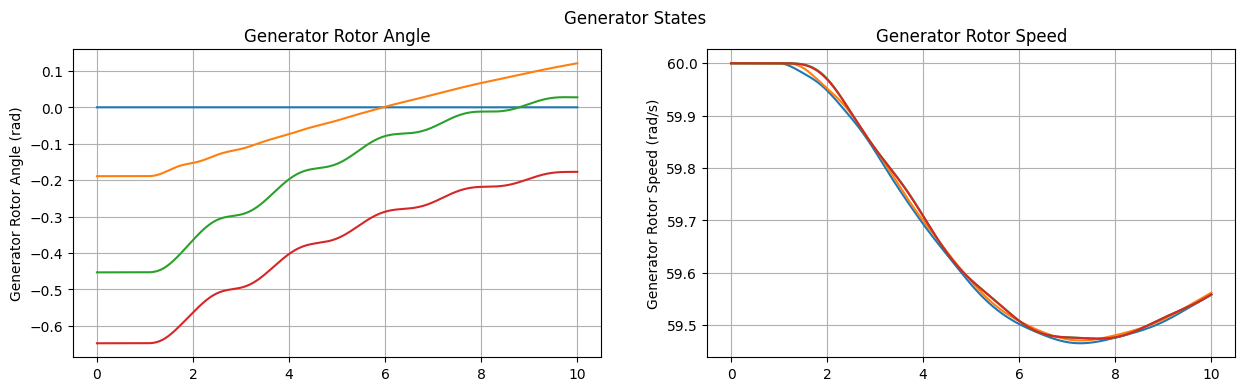

In [9]:
plt.rcParams["font.family"] = "serif"

xaxis = np.arange(0, Tlen+ts, DSrate*ts)
Genrou=np.matrix(list(emt.x.values()))
# Genrou=np.matrix(emt.x)
# plt.rc('font', family='Times New Roman', size=14)
fig, axs = plt.subplots(1,2, sharex=False, sharey=False, figsize=(15, 4))
fig.suptitle("Generator States")

# No 1, synchronous generator Delta angle
axs[0].plot(xaxis, Genrou[:,0:dyd.gen_genrou_odr*len(pfd.gen_bus):dyd.gen_genrou_odr]-Genrou[:,0], linestyle="-")
axs[0].set(ylabel="Generator Rotor Angle (rad)")
axs[0].set_title("Generator Rotor Angle") 
axs[0].grid(True)

# No 2, synchronous generator rotor frequency
axs[1].plot(xaxis, Genrou[:,1:dyd.gen_genrou_odr*len(pfd.gen_bus):dyd.gen_genrou_odr]/2/np.pi, linestyle="-")
axs[1].set(ylabel="Generator Rotor Speed (rad/s)")
axs[1].set_title("Generator Rotor Speed") 
# axs[1].set_ylim(59, 60.05)
axs[1].grid(True)

plt.savefig("Figure_ParaEMT_Generator.png", format="png")  
plt.draw()
plt.show() 

Example 2: plot three phase voltage at Bus 1 and Bus 2

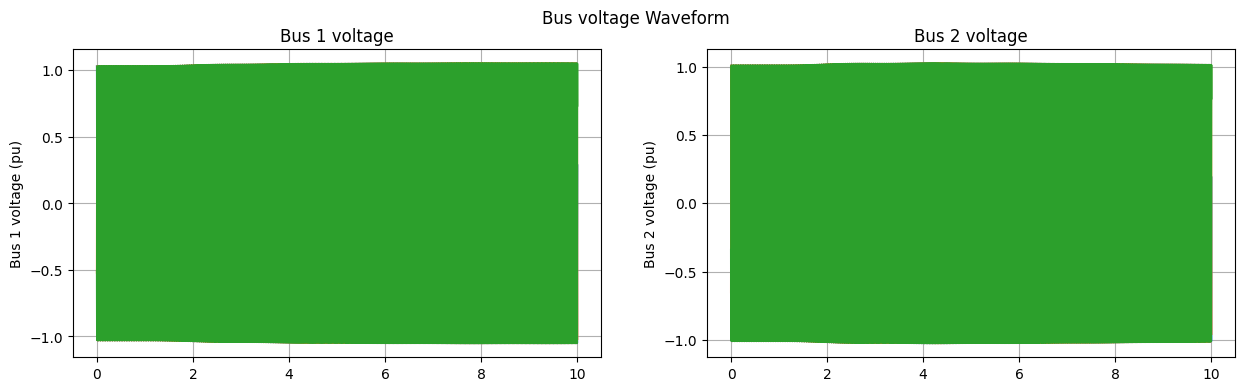

In [10]:
V_network=np.matrix(list(emt.v.values()))

# plt.rc('font', family='Times New Roman', size=14)
fig, axs = plt.subplots(1,2, sharex=False, sharey=False, figsize=(15, 4))
fig.suptitle("Bus voltage Waveform")
# No 1, Voltage waveform at bus1
Bus1=0
axs[0].plot(xaxis, V_network[:,Bus1:3*len(pfd.bus_num):len(pfd.bus_num)], linestyle="-")
axs[0].set(ylabel=f"Bus {Bus1+1} voltage (pu)")
axs[0].set_title(f"Bus {Bus1+1} voltage")
axs[0].grid(True)
    
# No 2, Voltage waveform at bus 2
Bus2=Bus1+1
axs[1].plot(xaxis, V_network[:,Bus2:3*len(pfd.bus_num):len(pfd.bus_num)], linestyle="-")
axs[1].set(ylabel=f"Bus {Bus2+1} voltage (pu)")
axs[1].set_title(f"Bus {Bus2+1} voltage")
axs[1].grid(True)

plt.savefig("Figure_ParaEMT_EPRI_3phaseV.png", format="png")  
plt.draw()
plt.show() 

Save simulation results as .pkl files

In [11]:
emt.dump_res(pfd, dyd, ini, SimMod, output_snp_ful, output_snp_1pt, output_res)

Finally, save simulation results as .csv files

In [12]:
Vbus = []
for j in range(3):  # Three phase
    if j==0:
        V_phase='Va'
    if j==1:
        V_phase='Vb'
    if j==2:
        V_phase='Vc'
    for i in range(len(pfd.bus_num)):
        Vbus.append(str(pfd.bus_num[i]) + '_' + pfd.bus_name[i] + '_' + V_phase)
dfbus = pd.DataFrame(np.transpose(emt.v))
dfbus.to_csv("emt_3phaseV.csv", header=Vbus, index=False)

Cbus = []
for i in range(len(pfd.bus_num)):
    Cbus.append(str(pfd.bus_num[i]) + '_' + pfd.bus_name[i] + '_' + 'ze')
    Cbus.append(str(pfd.bus_num[i]) + '_' + pfd.bus_name[i] + '_' + 'de')
    Cbus.append(str(pfd.bus_num[i]) + '_' + pfd.bus_name[i] + '_' + 'we')
    Cbus.append(str(pfd.bus_num[i]) + '_' + pfd.bus_name[i] + '_' + 'vt')
    Cbus.append(str(pfd.bus_num[i]) + '_' + pfd.bus_name[i] + '_' + 'vtm')
    Cbus.append(str(pfd.bus_num[i]) + '_' + pfd.bus_name[i] + '_' + 'dvtm')

if len(pfd.bus_num) > 0:
    dfbus = pd.DataFrame(np.transpose(emt.x_bus))
    dfbus.to_csv("emt_x_bus.csv", header=Cbus, index=False)

C = ['Time']
for i in range(dyd.gen_genrou_n):
    C.append(str(pfd.gen_bus[i]) + '_' + pfd.gen_id[i] + '_' + 'dt')
    C.append(str(pfd.gen_bus[i]) + '_' + pfd.gen_id[i] + '_' + 'w')
    C.append(str(pfd.gen_bus[i]) + '_' + pfd.gen_id[i] + '_' + 'id')
    C.append(str(pfd.gen_bus[i]) + '_' + pfd.gen_id[i] + '_' + 'iq')
    C.append(str(pfd.gen_bus[i]) + '_' + pfd.gen_id[i] + '_' + 'ifd')
    C.append(str(pfd.gen_bus[i]) + '_' + pfd.gen_id[i] + '_' + 'i1d')
    C.append(str(pfd.gen_bus[i]) + '_' + pfd.gen_id[i] + '_' + 'i1q')
    C.append(str(pfd.gen_bus[i]) + '_' + pfd.gen_id[i] + '_' + 'i2q')
    C.append(str(pfd.gen_bus[i]) + '_' + pfd.gen_id[i] + '_' + 'ed')
    C.append(str(pfd.gen_bus[i]) + '_' + pfd.gen_id[i] + '_' + 'eq')
    C.append(str(pfd.gen_bus[i]) + '_' + pfd.gen_id[i] + '_' + 'psyd')
    C.append(str(pfd.gen_bus[i]) + '_' + pfd.gen_id[i] + '_' + 'psyq')
    C.append(str(pfd.gen_bus[i]) + '_' + pfd.gen_id[i] + '_' + 'psyfd')
    C.append(str(pfd.gen_bus[i]) + '_' + pfd.gen_id[i] + '_' + 'psy1q')
    C.append(str(pfd.gen_bus[i]) + '_' + pfd.gen_id[i] + '_' + 'psy1d')
    C.append(str(pfd.gen_bus[i]) + '_' + pfd.gen_id[i] + '_' + 'psy2q')
    C.append(str(pfd.gen_bus[i]) + '_' + pfd.gen_id[i] + '_' + 'te')
    C.append(str(pfd.gen_bus[i]) + '_' + pfd.gen_id[i] + '_' + 'qe')

for i in range(dyd.exc_sexs_n):
    C.append(str(pfd.gen_bus[i]) + '_' + pfd.gen_id[i] + '_SEXS_' + 'v1')
    C.append(str(pfd.gen_bus[i]) + '_' + pfd.gen_id[i] + '_SEXS_' + 'EFD')

for i in range(dyd.gov_tgov1_n):
    j = int(dyd.gov_tgov1_idx[i])
    C.append(str(pfd.gen_bus[j]) + '_' + pfd.gen_id[j] + '_TGOV1_' + 'P1')
    C.append(str(pfd.gen_bus[j]) + '_' + pfd.gen_id[j] + '_TGOV1_' + 'P2')
    C.append(str(pfd.gen_bus[j]) + '_' + pfd.gen_id[j] + '_TGOV1_' + 'Pm')

for i in range(dyd.gov_hygov_n):
    j = int(dyd.gov_hygov_idx[i])
    C.append(str(pfd.gen_bus[j]) + '_' + pfd.gen_id[j] + '_HYGOV_' + 'xe')
    C.append(str(pfd.gen_bus[j]) + '_' + pfd.gen_id[j] + '_HYGOV_' + 'xc')
    C.append(str(pfd.gen_bus[j]) + '_' + pfd.gen_id[j] + '_HYGOV_' + 'xg')
    C.append(str(pfd.gen_bus[j]) + '_' + pfd.gen_id[j] + '_HYGOV_' + 'xq')
    C.append(str(pfd.gen_bus[j]) + '_' + pfd.gen_id[j] + '_HYGOV_' + 'Pm')

for i in range(dyd.gov_gast_n):
    j = int(dyd.gov_gast_idx[i])
    C.append(str(pfd.gen_bus[j]) + '_' + pfd.gen_id[j] + '_GAST_' + 'P1')
    C.append(str(pfd.gen_bus[j]) + '_' + pfd.gen_id[j] + '_GAST_' + 'P2')
    C.append(str(pfd.gen_bus[j]) + '_' + pfd.gen_id[j] + '_GAST_' + 'P3')
    C.append(str(pfd.gen_bus[j]) + '_' + pfd.gen_id[j] + '_GAST_' + 'Pm')

for i in range(dyd.pss_ieeest_n):
    j = int(dyd.pss_ieeest_idx[i])
    C.append(str(pfd.gen_bus[j]) + '_' + pfd.gen_id[j] + '_IEEEST_' + 'y1')
    C.append(str(pfd.gen_bus[j]) + '_' + pfd.gen_id[j] + '_IEEEST_' + 'y2')
    C.append(str(pfd.gen_bus[j]) + '_' + pfd.gen_id[j] + '_IEEEST_' + 'y3')
    C.append(str(pfd.gen_bus[j]) + '_' + pfd.gen_id[j] + '_IEEEST_' + 'y4')
    C.append(str(pfd.gen_bus[j]) + '_' + pfd.gen_id[j] + '_IEEEST_' + 'y5')
    C.append(str(pfd.gen_bus[j]) + '_' + pfd.gen_id[j] + '_IEEEST_' + 'y6')
    C.append(str(pfd.gen_bus[j]) + '_' + pfd.gen_id[j] + '_IEEEST_' + 'y7')
    C.append(str(pfd.gen_bus[j]) + '_' + pfd.gen_id[j] + '_IEEEST_' + 'x1')
    C.append(str(pfd.gen_bus[j]) + '_' + pfd.gen_id[j] + '_IEEEST_' + 'x2')
    C.append(str(pfd.gen_bus[j]) + '_' + pfd.gen_id[j] + '_IEEEST_' + 'vs')

Cibr = []
for i in range(dyd.ibr_n):
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_regca_' + 's0')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_regca_' + 's1')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_regca_' + 's2')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_regca_' + 'Vmp')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_regca_' + 'Vap')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_regca_' + 'i1')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_regca_' + 'i2')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_regca_' + 'ip2rr')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_reecb_' + 's0')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_reecb_' + 's1')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_reecb_' + 's2')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_reecb_' + 's3')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_reecb_' + 's4')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_reecb_' + 's5')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_reecb_' + 'Ipcmd')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_reecb_' + 'Iqcmd')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_reecb_' + 'Pref')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_reecb_' + 'Qref')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_reecb_' + 'q2vPI')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_reecb_' + 'v2iPI')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 's0')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 's1')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 's2')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 's3')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 's4')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 's5')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 's6')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 'Vref')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 'Qref')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 'Freq_ref')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 'Plant_ref')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 'LineMW')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 'LineMvar')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 'LineMVA')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 'QVdbout')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 'fdbout')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 'vq2qPI')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 'p2pPI')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 'Vf')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 'Pe')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 'Qe')
    
t = emt.t.reshape(len(emt.t), 1)
x = np.insert(np.transpose(emt.x), 0, np.transpose(t), axis = 1)
df = pd.DataFrame(x)
df.to_csv("emt_x.csv", header = C, index = False)

if len(pfd.ibr_bus)>0:
    dfibr = pd.DataFrame(np.transpose(emt.x_ibr))
    dfibr.to_csv("emt_xibr.csv", header=Cibr, index=False)

Cload = []
for i in range(len(pfd.load_bus)):
    Cload.append(str(pfd.load_bus[i]) + '_' + pfd.load_id[i] + '_' + 'ZL_mag')
    Cload.append(str(pfd.load_bus[i]) + '_' + pfd.load_id[i] + '_' + 'ZL_ang')
    Cload.append(str(pfd.load_bus[i]) + '_' + pfd.load_id[i] + '_' + 'PL')
    Cload.append(str(pfd.load_bus[i]) + '_' + pfd.load_id[i] + '_' + 'QL')
if len(pfd.load_bus)>0:
    dfLd = pd.DataFrame(np.transpose(emt.x_load))
    dfLd.to_csv("emt_x_load.csv", header=Cload, index=False)

Download all saved files from Google colab virtual machine:

In [ ]:
# Create a zip file
files_to_zip = ['emt_3phaseV.csv', 'emt_x_bus', 'emt_x', 'emt_xibr', 'emt_x_load', 'Figure_ParaEMT_EPRI_3phaseV.png', 'Figure_ParaEMT_Generator.png'] 
shutil.make_archive('files_archive', 'zip', '.', files_to_zip)
from google.colab import files
files.download('files_archive.zip')
